In [ ]:
#| hide
#| default_exp optimize
from nbdev import *

# Distribution reshape

> Post-processing procedure to match the sampling set to the target distribution by adjusting the data weights in the sample. 

This code is an implementation of the idea to replace crude weighting produced by the Metropolis-Hastings algorithm by weights derived directly from the PDF of the target distribution. This makes the acceptance ratio essentially 100% and allows for tricks like changing of the target distribution (e.g. shifting of the target temperature of the sample or even scanning of the temperature range using prior distribution generated using `plan_T_scan`).

The implementation here, derives the weights directly from the PDF of the target distribution by assigning non-uniform bins to each data point and calculating change in CDF  across each bin. The resulting data uses weighting in similar way as the M-H sampling does, but exploits the knowledge of the sample distribution and target PDF to make it more effective.

In [ ]:
#| hide
#| exporti
from scipy import stats
from matplotlib import pylab as plt
import ase.units as un
import numpy as np
from hecss.util import flatten

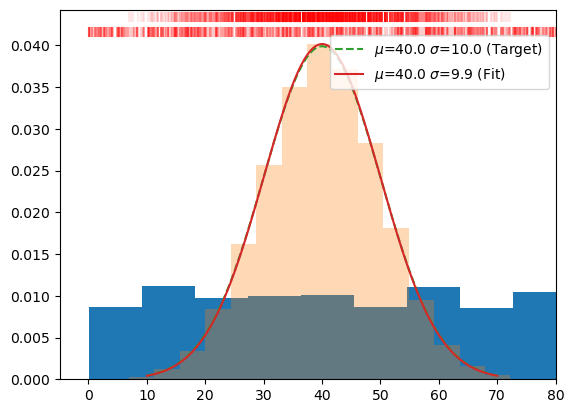

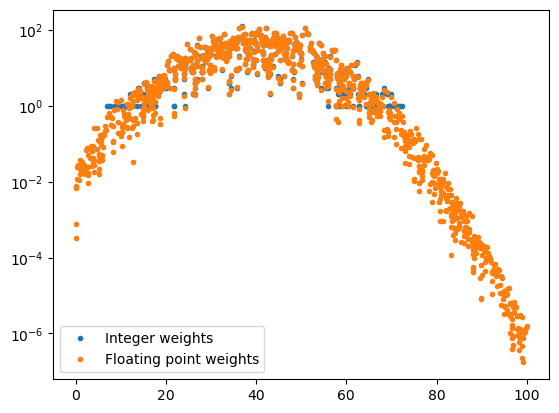

In [ ]:
#| hide
def refit(data, mu, sigma, sigma_scale=1.0, probTH=0.25, 
          Nmul=4, N=None, Nb=None, target=stats.norm):
    '''
    Re-shaper of the data distribution.
    This is internal function used for experimentation.
    '''
    # Data multiplication factor
    if N is None:
        N = Nmul*len(data)
    
    # Target distribution
    # You can use slightly (5% for N=10*len(data)) smaller sigma 
    # to compensate for the missing tails below weight=1
    g = target(mu, sigma_scale*sigma)
    d = np.sort(data)
    
    # Make bins for PDF evaluation
    # Each data point gets its own bin by splitting 
    # the distance between data points in half.
    # The boundary points get symmetrical bins.
    bb = np.zeros(len(d)+1)
    bb[1:-1] = (d[:-1]+d[1:])/2
    bb[0] = d[0]-(d[1]-d[0])/2
    bb[-1] = d[-1]+(d[-1]-d[-2])/2
    # bin widths
    bw = bb[1:]-bb[:-1]

    cdf = g.cdf(bb)
    w = cdf[1:]-cdf[:-1]

    # Data weights to fit the target distribution
    # w = g.pdf(bp)*bw
    w /= w.sum()
    nf = N
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    # iw = np.round(w*nf) + (1*(np.abs(d - mu) < 3*sigma))
    iw = nf*w
    # Don't remove low probability data, rise weights above probTH
    # This will deform (rise) the wings of the histogram
    iw[np.logical_and(probTH<iw, iw<1)]=1
    iw = np.round(iw)

    # Weight the data by multiplication of data points
    wd = list(flatten([int(ww)*[dd] for ww, dd in zip(iw,d) if ww>=1]))

    if Nb is None :
        Nb = min(len(data)//4, 15)
        
    h, b, _ = plt.hist(wd, bins=Nb, density=True, alpha=0.3);
    x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
    fit = target.fit(wd)
    plt.plot( x, target.pdf(x, mu, sigma), '--', label=f'$\mu$={mu:.1f} $\sigma$={sigma:.1f} (Target)' )
    plt.plot( x, target.pdf(x, *fit), label=f'$\mu$={fit[0]:.1f} $\sigma$={fit[1]:.1f} (Fit)' )
    skip = len(d)//2000
    skip = int(max(1, skip))
    nf = (iw[::skip]).max()
    for s, a in zip(d[::skip], iw[::skip]):
        if a<1e-3:
            continue
        plt.axvline(s, ymin=0.97, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
    
    return w, iw, wd

N = 1_000
d = np.sort(stats.uniform.rvs(0, 100, size=N))
plt.hist(d, bins='auto', density=True);
skip = len(d)//2000
skip = int(max(1, skip))
for s in d[::skip]:
    plt.axvline(s, ymin=0.93, ymax=0.95, ls='-', color='r', alpha=0.2)              
m = 40
s = 10
fw, iw, wd = refit(d, m, s, probTH=0.5, N=10*len(d))
plt.xlim(None, m+4*s)
plt.ylim(None, 1.05*plt.ylim()[1])
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));

plt.show()
plt.semilogy()
plt.plot(d[iw>0], iw[iw>0], '.', label='Integer weights')
plt.plot(d, len(wd)*fw, '.', label='Floating point weights')
plt.legend();

In [ ]:
#| hide
#| asap

from hecss.monitor import plot_stats, plot_virial_stat, plot_xs_stat
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat
from hecss.util import select_asap_model, create_asap_calculator
from hecss import HECSS
from ase.build import bulk
from ase.spacegroup import crystal

In [ ]:
#| hide
#| asap

model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '1x1x1'
sys_size = '2x2x2'
sys_size = '3x3x3'
sys_size = '4x4x4'
sys_size = '5x5x5'
sc = [int(v) for v in sys_size.split('x')]
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.calc = create_asap_calculator(model)

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


  0%|          | 0/500 [00:00<?, ?it/s]

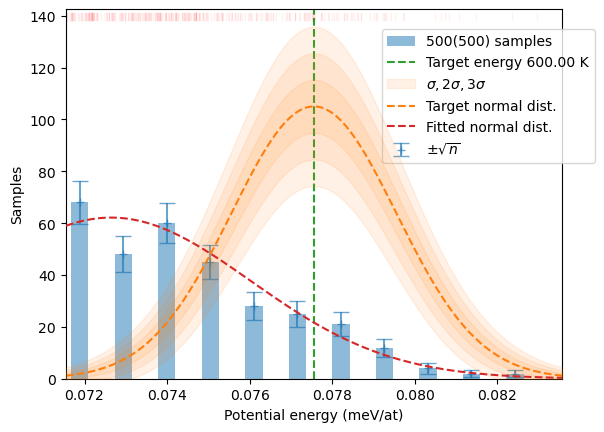

In [ ]:
#| hide
#| asap

T = 600
N = 500

hecss = HECSS(cryst, lambda : create_asap_calculator(model), disp_dist='laplace',
              width=1.05, pbar=True, w_search=False)

smpls = hecss.sample(T, N)
plot_stats(smpls, T, sqrN=True, show=False)
plt.savefig('AUX/hecss_prior.pdf', bbox_inches='tight')

In [ ]:
#| export
def get_sample_weights(data, T, sigma_scale=1.0, border=False, debug=False):
    '''
    Generate data weights making the probability distribution of `data` in 
    sample format into normal distribution corresponding to temperature `T`.
    The actual distribution traces the normal curve. Normally, no weight 
    is given to the data outside the input data range. This may skew the 
    resulting distribution and shift its parameters but avoids nasty border
    artefacts in the form of large weights given to border samples to account 
    for the rest of the domain. You can switch this behavior on by passing 
    `border` parameter (not recommended).
    
    #### Input
    * `data`        - list of samples generated by HECSS sampler ([n, i, x, f, e])
    * `T`           - temperature in kelvin
    * `sigma_scale` - scaling factor for variance. Defaults to 1.0.
    * `border`      - make border samples account for unrepresented part of domain
    * `debug`       - plot diagnostic plots
    
    #### Output (weights, index)
    * weights     - array of weights in sorted energy order
    * index       - indexing array which sorts samples by energy
    
    '''
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    # You can use slightly (10%) wider sigma to compensate 
    # for the missing tails below weight=1
    g = stats.norm(mu, sigma_scale*sigma)
    e = np.fromiter((s[-1] for s in data), float)
    idx = np.argsort(e)
    ridx = np.arange(len(idx))[idx]
    d = e[idx]
    if debug:
        N_bins = max(len(data)//20, 20)
        data_range = 4*sigma
        plt.hist(d, range=(mu-data_range, mu+data_range), bins=N_bins,
                 histtype='step', density=True, alpha=0.75, 
                 label='Input histogram')
        plt.plot(d, -0.05*g.pdf(mu)*np.ones(d.shape), '|', 
                 alpha=max(0.01, min(1.0, 100/len(d))))
        plt.axhline(lw=1, ls=':')
        
    bb = np.zeros(len(d)+1)
    bb[1:-1] = (d[:-1]+d[1:])/2
    bb[0] = d[0]-(d[1]-d[0])/2
    bb[-1] = d[-1]+(d[-1]-d[-2])/2
    # bin widths
    bw = bb[1:]-bb[:-1]

    cdf = g.cdf(bb)
    if border:
        # make border sample account for the rest of the domain
        cdf[0]=0
        cdf[-1]=1
    
    w = cdf[1:]-cdf[:-1]
    w /= w.sum()
    if debug:
        plt.stairs(w/bw, bb, fill=False, lw=1, label='Weighted samples')
        x = np.linspace(mu-data_range, mu+data_range, 100)
        # The norm of the pdf is adiusted according to the norm
        # inside the represented domain
        plt.plot(x, g.pdf(x)/(cdf[-1]-cdf[0]), '-', label='Target')
        plt.hist(d, weights=w, range=(mu-data_range, mu+data_range), 
                 bins=N_bins, density=True, alpha=0.3, label='Weighted histogram')
        plt.xlim(mu-data_range, mu+data_range)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
        plt.show()

    return w, idx

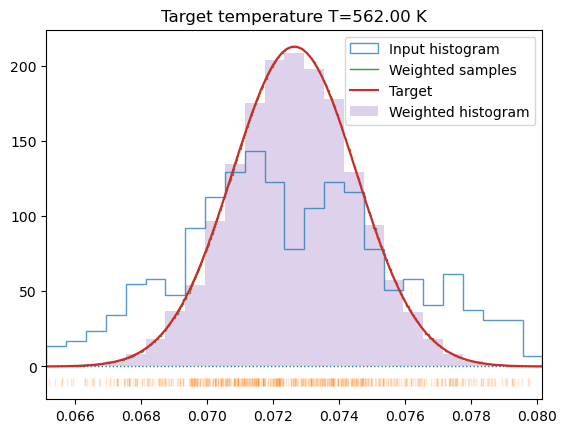

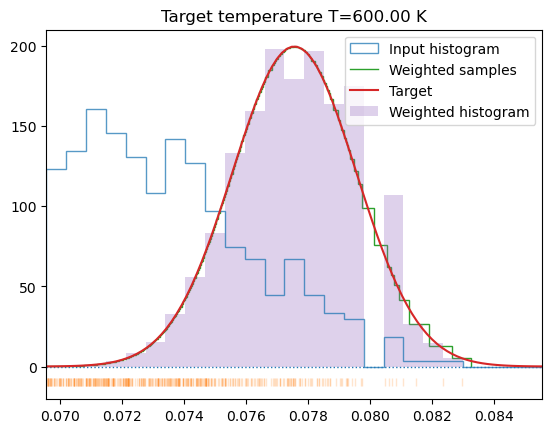

In [ ]:
#| asap

# Calculate the mean of the sample
# We do not care too much about which temperature we got
# Just if we are in equilibrium
Tmu = np.fromiter((s[-1] for s in smpls), float).mean()
Tmu *= 2/un.kB/3

# Get weights for this temperature
plt.title(f'Target temperature T={Tmu:.2f} K')
wgh, idx =  get_sample_weights(smpls, Tmu, border=False, debug=True)

# and now for actual target temperature T
plt.title(f'Target temperature T={T:.2f} K')
wgh, idx =  get_sample_weights(smpls, T, border=False, debug=True)

In [ ]:
#| export
def make_sampling(data, T, sigma_scale=1.0, border=False, probTH=0.25, 
                  Nmul=4, N=None, nonzero_w=True, debug=False):
    '''
    Generate new sample with normal energy probability distribution
    corresponding to temperature `T` and size of the system inferred 
    from data. The output is generated by multiplying samples 
    proportionally to the wegihts generated by `get_sample_weights`
    and assuming the final dataset will be `Nmul` times longer 
    (or the length `N` which takes precedence). If `nonzero_w` is `True`
    the data multiplyers in the range (probTH, 1) will be clamped to 1,
    to avoid losing low-probability data. This will obviously deform the
    distribution but may be beneficial for the interaction model constructed
    from the data. The data on output will be ordered in increasing energy
    and re-numbered. The configuration index is retained.
    
    #### Input
    * `data`        - list of samples generated by HECSS sampler ([n, i, x, f, e])
    * `T`           - temperature in kelvin
    * `sigma_scale` - scaling factor for variance. Defaults to 1.0.
    * `border`      - make border samples account for unrepresented part of domain
    * `probTH`      - threshold for probability (N*weight) clamping.
    * `Nmul`        - data multiplication factor. The lenght of output data will be
                      approximately `Nmul*len(data)`.
    * `N`           - approximate output data length. Takes precedence over `Nmul`
    * `nonzero_w`   - prevent zero weights for data with weights in (probTH, 1) range
    * `debug`       - plot diagnostic plots
    
    #### Output
    Weighted, sorted by energy and re-numbered samples as a new list. 
    The data in the list is just reference-duplicated, not copied.
    Thus the data elements should not be modified.
    The format is the same as the data produced by `HECSS` sampler.
    
    '''
    if N is None:
        N = int(Nmul*len(data))
        
    if Nmul>25 :
        print('Warning: You cannot generate data from thin air.\n'
              'Nmul above 25 is pointless. Doing it anyway.')

    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    w, idx = get_sample_weights(data, T, sigma_scale=sigma_scale, border=border, debug=debug)
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    # iw = np.round(w*nf) + (1*(np.abs(d - mu) < 3*sigma))
    iw = N*w
    if nonzero_w:
        # Don't remove low probability data, rise weights above probTH
        # This will deform (rise) the wings of the histogram
        iw[np.logical_and(probTH<iw, iw<1)]=1
    iw = np.rint(iw)

    # Weight the data by multiplication of data points
    # The output will be in energy order!
    wd = []
    iwnorm = iw.sum()
    for ww, ii in zip(iw,idx):
        if ww<1:
            continue
        wd += int(ww)*[data[ii]]
    # renumber the samples
    wd = [(n,)+d[1:] for n, d in enumerate(wd)]

    if debug:
        N_bins = max(len(data)//20, 20)
        data_range = 4*sigma
        e = np.fromiter((data[i][-1] for i in idx), float)
        plt.hist(e, weights=w, range=(mu-data_range, mu+data_range), 
                 bins=N_bins, density=True, alpha=0.3,
                 label='Float weights');
        wde = np.fromiter((s[-1] for s in wd), float)
        # h, b, _ = 
        plt.hist(wde, range=(mu-data_range, mu+data_range), 
                 histtype='step', bins=N_bins, density=True, alpha=0.75,
                 label='Integer weights');
        x = np.linspace(mu-data_range, mu+data_range, 300)
        fit = stats.norm.fit(wde)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), '--', 
                 label=f'$\mu$={2*mu/3/un.kB:.1f}; $\sigma$={2*sigma/3/un.kB:.1f} (Target)' )
        plt.plot(x, stats.norm.pdf(x, *fit), 
                 label=f'$\mu$={2*fit[0]/3/un.kB:.1f}; $\sigma$={2*fit[1]/3/un.kB:.1f} (Fit)' )
        plt.title('Generated weighted sample')
        skip = len(data)//2000
        skip = int(max(1, skip))
        # nf = (w[::skip]).max()
        mh = stats.norm.pdf(mu, mu, sigma)
        plt.plot(e[::skip], -0.05*mh*np.ones(e[::skip].shape), '|', color='C1', 
                 alpha=max(0.01, min(1.0, 100/len(e))))
        plt.axhline(lw=1, ls=':')
        plt.xlim(mu-data_range, mu+data_range)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0));
    
    return wd

In [ ]:
#| hide
#| asap

wd = make_sampling(smpls, T, probTH=0, Nmul=1/len(smpls), 
                   nonzero_w=True, border=False, debug=False)

assert len(wd)==len(smpls)

## Target temperature control

If the amplitude of displacement is not tightly controlled by the width searching algorithm (`w_search` parameter in the `HECSS` constructor), the mean energy of the sample will be shifted from the target value. The distribution reshaping algorithm in `make_sampling` may shift the result closer to the target but cannot create data out of thin air. This is illustrated in the example below. In first case (@sec-shifted_target) we have forced the algorithm to create distribution at initial target temperature (`T`), which produces very distorted sample.

In the second case (@sec-mean_target) the target temperature is selected well within the data domain (`Tmu` which is actually the mean of the sample) which generates a well-balanced and uniform sampling of the target distribution, although at a slightly shifted temperature.

### Shifted target {#sec-shifted_target}

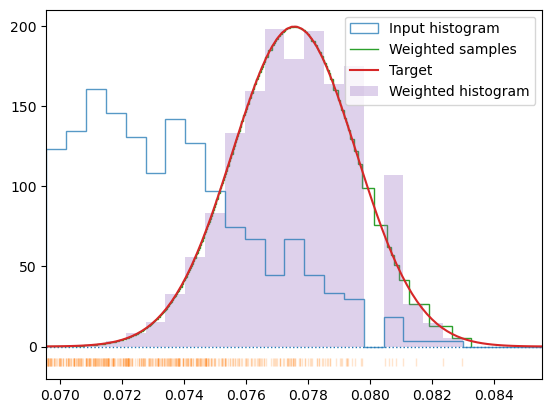

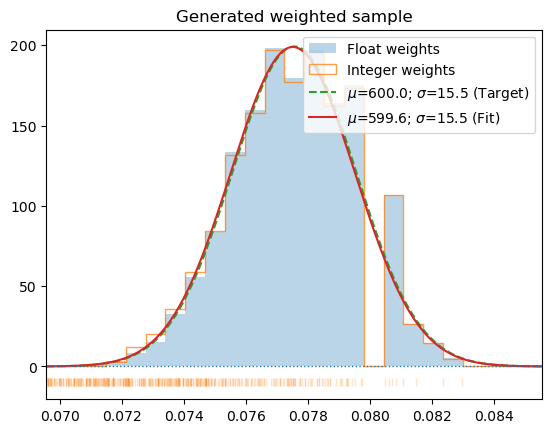

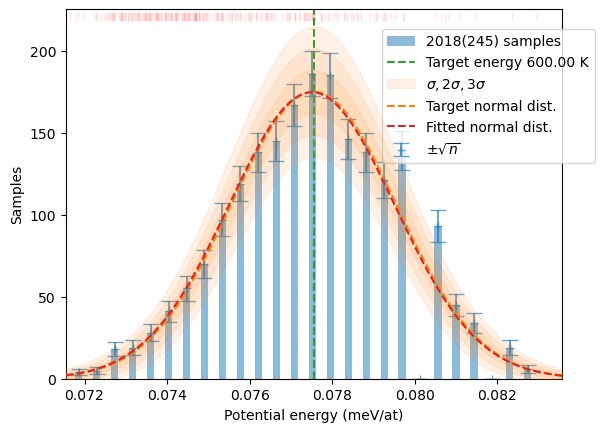

In [ ]:
#| asap

wd = make_sampling(smpls, T, probTH=0.25, Nmul=4, 
                   nonzero_w=True, border=False, debug=True)
plt.show()
plot_stats(wd, T, sqrN=True, show=False)
# plt.savefig('AUX/hecss_post.pdf', bbox_inches='tight')

### Target at the mean {#sec-mean_target}

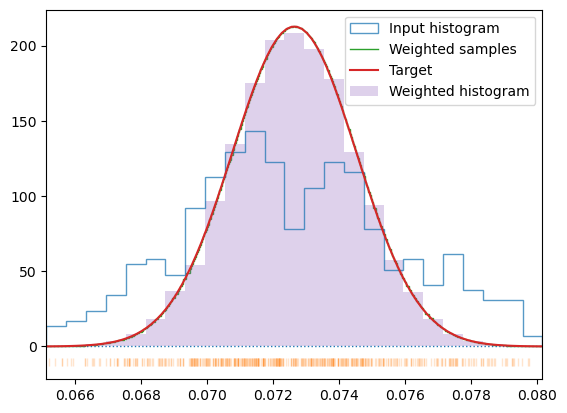

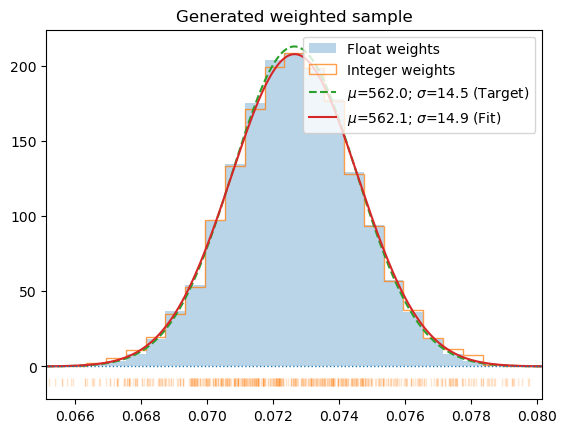

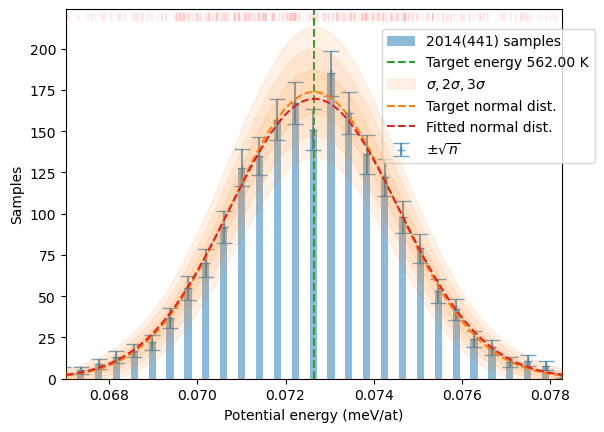

In [ ]:
#| asap

wd = make_sampling(smpls, Tmu, probTH=0.25, Nmul=4, 
                   nonzero_w=True, border=False, debug=True)
plt.show()
plot_stats(wd, Tmu, sqrN=True, show=False)
# plt.savefig('AUX/hecss_post.pdf', bbox_inches='tight')

## Manual temperature scan

The ability to re-shape the sample makes it possible to scan the whole range of temperatures by adding samples from several temperatures and subsequently drawing from the whole set samples representing any target temperature in the covered range. The sampled temperatures may be selected manually or using automatic procedure from `plan_T_scan`. Here we just select few temperatures and run the procedure to test the weighting procedure on the non-gaussian prior.

In [ ]:
#| asap

uni = {TT:hecss.sample(TT, N) for TT in (260, 300, 340)}

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

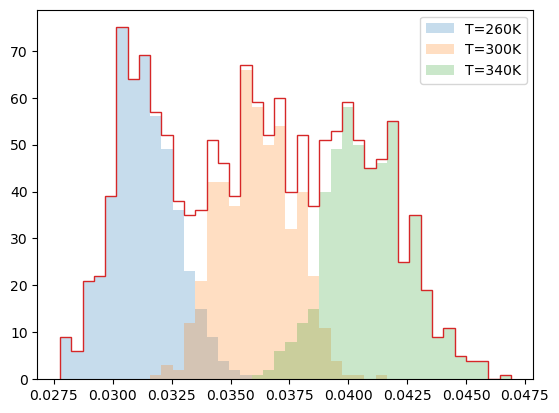

In [ ]:
#| asap

e_dist = {t:np.array([s[-1] for s in d]) for t, d in uni.items()}
e_uni = np.concatenate(tuple(e_dist.values()))
usmp = []
for s in uni.values():
    usmp += s

for TT, ed in e_dist.items():
    plt.hist(ed, bins=40, label=f'T={TT}K', alpha=0.25, range=(e_uni.min(), e_uni.max()))
plt.hist(e_uni, bins=40, histtype='step', stacked=True, range=(e_uni.min(), e_uni.max()))
plt.legend();

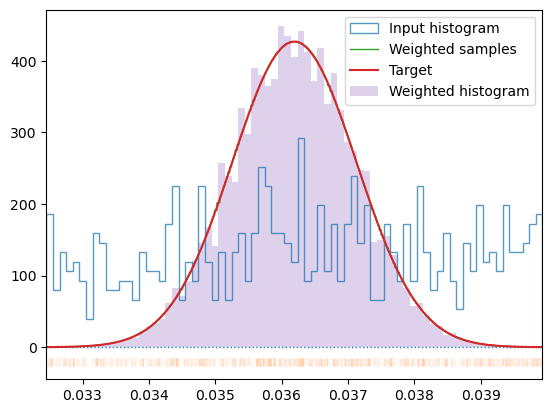

1500 2026


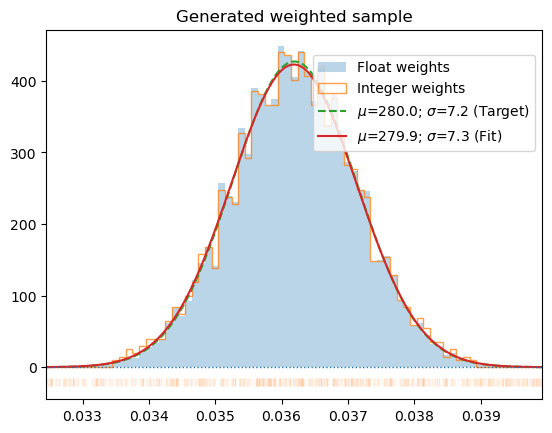

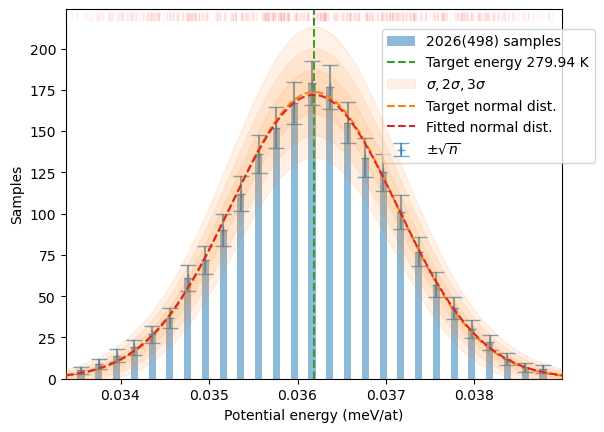

In [ ]:
#| asap
 
wd = make_sampling(usmp, T=280, N=4*N, nonzero_w=True, debug=True)
print(len(usmp), len(wd))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))
plt.show();
plot_stats(wd, sqrN=True, show=False)
plt.savefig(f'AUX/T_fit_{T=:.0f}K.pdf', bbox_inches='tight')